In [1]:
%pip install plotly
%pip install nbformat

Note: you may need to restart the kernel to use updated packages.



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from scipy.stats import zscore
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('Electric_Vehicles.csv')

In [4]:
#Optimising memory by appling correct data types to features
df = df.astype({
    'User ID': 'str',
    'Vehicle Model': 'category',
    'Charging Station ID': 'str',
    'Charging Station Location': 'category',
    'Charging Start Time': 'datetime64[ns]',
    'Charging End Time': 'datetime64[ns]',
    'Time of Day': 'category',
    'Day of Week': 'category',
    'Charger Type': 'category',
    'User Type': 'category'
})

print(df.dtypes)


#Replace missing values with median
df[['Energy Consumed (kWh)', 'Charging Rate (kW)', 'Distance Driven (since last charge) (km)']] = df[['Energy Consumed (kWh)', 'Charging Rate (kW)', 'Distance Driven (since last charge) (km)']].fillna(df[['Energy Consumed (kWh)', 'Charging Rate (kW)', 'Distance Driven (since last charge) (km)']].median())

df.isnull().sum()

User ID                                             object
Vehicle Model                                     category
Battery Capacity (kWh)                             float64
Charging Station ID                                 object
Charging Station Location                         category
Charging Start Time                         datetime64[ns]
Charging End Time                           datetime64[ns]
Energy Consumed (kWh)                              float64
Charging Duration (hours)                          float64
Charging Rate (kW)                                 float64
Charging Cost (USD)                                float64
Time of Day                                       category
Day of Week                                       category
State of Charge (Start %)                          float64
State of Charge (End %)                            float64
Distance Driven (since last charge) (km)           float64
Temperature (°C)                                   float

User ID                                     0
Vehicle Model                               0
Battery Capacity (kWh)                      0
Charging Station ID                         0
Charging Station Location                   0
Charging Start Time                         0
Charging End Time                           0
Energy Consumed (kWh)                       0
Charging Duration (hours)                   0
Charging Rate (kW)                          0
Charging Cost (USD)                         0
Time of Day                                 0
Day of Week                                 0
State of Charge (Start %)                   0
State of Charge (End %)                     0
Distance Driven (since last charge) (km)    0
Temperature (°C)                            0
Vehicle Age (years)                         0
Charger Type                                0
User Type                                   0
dtype: int64

## Checking for logical inconsistencies

In [5]:
inconsistent_charge = df[df['State of Charge (Start %)'] > df['State of Charge (End %)']]
print("Inconsistent charges: ", len(inconsistent_charge))


print("\nInconsistent stations:")
inconsistent_stations = df.groupby('Charging Station ID')['Charging Station Location'].nunique()
inconsistent_stations = inconsistent_stations[inconsistent_stations > 1]
print(inconsistent_stations.head(100))  


# Check for negative values
print("\n\nRows with Negative Energy Consumed:")
print(df[df['Energy Consumed (kWh)'] < 0])

print("\n\nRows with Negative Distance Driven:")
print(df[df['Distance Driven (since last charge) (km)'] < 0])

Inconsistent charges:  268

Inconsistent stations:
Charging Station ID
Station_1      3
Station_10     4
Station_100    2
Station_101    3
Station_103    4
              ..
Station_213    2
Station_214    3
Station_215    2
Station_216    4
Station_217    2
Name: Charging Station Location, Length: 100, dtype: int64


Rows with Negative Energy Consumed:
Empty DataFrame
Columns: [User ID, Vehicle Model, Battery Capacity (kWh), Charging Station ID, Charging Station Location, Charging Start Time, Charging End Time, Energy Consumed (kWh), Charging Duration (hours), Charging Rate (kW), Charging Cost (USD), Time of Day, Day of Week, State of Charge (Start %), State of Charge (End %), Distance Driven (since last charge) (km), Temperature (°C), Vehicle Age (years), Charger Type, User Type]
Index: []


Rows with Negative Distance Driven:
Empty DataFrame
Columns: [User ID, Vehicle Model, Battery Capacity (kWh), Charging Station ID, Charging Station Location, Charging Start Time, Charging End Time

## One-hot encoding categorical data

In [ ]:
df = pd.get_dummies(df, columns=['Vehicle Model', 'Charging Station Location', 'Time of Day', 'Day of Week', 'Charger Type', 'User Type'], drop_first=True)

# Convert only one-hot encoded columns to integers
df = df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

In [7]:
print(df.dtypes)

User ID                                             object
Battery Capacity (kWh)                             float64
Charging Station ID                                 object
Charging Start Time                         datetime64[ns]
Charging End Time                           datetime64[ns]
Energy Consumed (kWh)                              float64
Charging Duration (hours)                          float64
Charging Rate (kW)                                 float64
Charging Cost (USD)                                float64
State of Charge (Start %)                          float64
State of Charge (End %)                            float64
Distance Driven (since last charge) (km)           float64
Temperature (°C)                                   float64
Vehicle Age (years)                                float64
Vehicle Model_Chevy Bolt                             int64
Vehicle Model_Hyundai Kona                           int64
Vehicle Model_Nissan Leaf                            int

In [8]:
df.shape #confirming no. of features increased from initial dataset

(1320, 35)

## Feature Engineering

In [11]:
df.head(5)

,User ID,Battery Capacity (kWh),Charging Station ID,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),State of Charge (Start %),...,Day of Week_Monday,Day of Week_Saturday,Day of Week_Sunday,Day of Week_Thursday,Day of Week_Tuesday,Day of Week_Wednesday,Charger Type_Level 1,Charger Type_Level 2,User Type_Commuter,User Type_Long-Distance Traveler
0,User_1,108.463007,Station_391,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,29.371576,...,0,0,0,0,1,0,0,0,1,0
1,User_2,100.000000,Station_428,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,10.115778,...,1,0,0,0,0,0,1,0,0,0
2,User_3,75.000000,Station_181,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,6.854604,...,0,0,0,1,0,0,0,1,1,0
3,User_4,50.000000,Station_327,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,83.120003,...,0,1,0,0,0,0,1,0,0,1
4,User_5,50.000000,Station_108,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,54.258950,...,0,1,0,0,0,0,1,0,0,1


In [9]:
df.columns

Index(['User ID', 'Battery Capacity (kWh)', 'Charging Station ID',
       'Charging Start Time', 'Charging End Time', 'Energy Consumed (kWh)',
       'Charging Duration (hours)', 'Charging Rate (kW)',
       'Charging Cost (USD)', 'State of Charge (Start %)',
       'State of Charge (End %)', 'Distance Driven (since last charge) (km)',
       'Temperature (°C)', 'Vehicle Age (years)', 'Vehicle Model_Chevy Bolt',
       'Vehicle Model_Hyundai Kona', 'Vehicle Model_Nissan Leaf',
       'Vehicle Model_Tesla Model 3', 'Charging Station Location_Houston',
       'Charging Station Location_Los Angeles',
       'Charging Station Location_New York',
       'Charging Station Location_San Francisco', 'Time of Day_Evening',
       'Time of Day_Morning', 'Time of Day_Night', 'Day of Week_Monday',
       'Day of Week_Saturday', 'Day of Week_Sunday', 'Day of Week_Thursday',
       'Day of Week_Tuesday', 'Day of Week_Wednesday', 'Charger Type_Level 1',
       'Charger Type_Level 2', 'User Type_Commut

In [44]:
# Extract hour of day from charging start & end time to understand charging behaviour throughout the day
df['Charging Start Hour'] = df['Charging Start Time'].dt.hour
df['Charging End Hour'] = df['Charging End Time'].dt.hour

# Weekend vs weekday: create binary feature for weekend (1) vs weekday (0)
df['Weekend'] = df['Charging Start Time'].dt.weekday >= 5  # 0 = Monday, 6 = Sunday

# Define peak hours (e.g., 8AM to 10AM and 5PM to 7PM are peak)
def peak_hours(hour):
    if (hour >= 8 and hour <= 10) or (hour >= 17 and hour <= 19):
        return 1  # Peak
    else:
        return 0  # Off-peak

df['Peak vs Off-Peak'] = df['Charging Start Hour'].apply(peak_hours)

# Vehicle efficiency
df['Vehicle Efficiency (kWh/km)'] = df['Energy Consumed (kWh)'] / df['Distance Driven (since last charge) (km)']

# Charger efficiency (Energy Consumed per Charging Duration)
df['Charger Efficiency (kWh/hour)'] = df['Energy Consumed (kWh)'] / df['Charging Duration (hours)']

# Interaction feature between 'Charger Efficiency' and 'Vehicle Age'
df['Charging Efficiency x Vehicle Age'] = df['Charger Efficiency (kWh/hour)'] * df['Vehicle Age (years)']

# State of charge change (end % - start %)
df['State of Charge Change (%)'] = df['State of Charge (End %)'] - df['State of Charge (Start %)']

# Calculate total charging sessions per station
df['Station Usage Count'] = df.groupby('Charging Station ID')['Charging Station ID'].transform('count')

# Avg energy consumed per user
df['Avg Energy Consumed Per User (kWh)'] = df.groupby('User ID')['Energy Consumed (kWh)'].transform('mean')

# Station usage intensity (how frequently a station is used, e.g., total charging sessions per station)
df['Station Usage Intensity'] = df.groupby('Charging Station ID')['Charging Station ID'].transform('count')

# Charging cost per hour (calculate cost per hour of charging)
df['Charging Cost Per Hour (USD/hr)'] = df['Charging Cost (USD)'] / df['Charging Duration (hours)']

# Average energy consumed by day (based on 'Charging Start Time')
df['Charging Date'] = df['Charging Start Time'].dt.date
df['Avg Energy Consumed Per Day (kWh)'] = df.groupby('Charging Date')['Energy Consumed (kWh)'].transform('mean')

# Average charging rate by vehicle model
df['Avg Charging Rate Per Vehicle (kW)'] = df.groupby(['Vehicle Model_Chevy Bolt', 
                                                       'Vehicle Model_Hyundai Kona', 
                                                       'Vehicle Model_Nissan Leaf', 
                                                       'Vehicle Model_Tesla Model 3'])['Charging Rate (kW)'].transform('mean')

# Cost for each charging session to identify which charging stations + user types are more cost-efficient
df['Cost Per kWh (USD)'] = df['Charging Cost (USD)'] / df['Energy Consumed (kWh)']

# Cross feature between time of day + day of week features to capture specific time patterns
df['Time of Day + Day of Week'] = df['Time of Day_Evening'].astype(str) + ' ' + df['Day of Week_Monday'].astype(str)

# Cross feature between charger type and user type
df['Charger Type + User Type'] = df['Charger Type_Level 1'].astype(str) + ' ' + df['User Type_Commuter'].astype(str)

# Average charging duration per vehicle
df['Avg Charging Duration Per Vehicle (hrs)'] = df.groupby('Vehicle Model_Chevy Bolt')['Charging Duration (hours)'].transform('mean')

# Standard deviation of charging rates per station
df['Std Dev Charging Rate Per Station (kW)'] = df.groupby('Charging Station ID')['Charging Rate (kW)'].transform('std')

# Skewness of charging duration per station
df['Charging Duration Skewness Per Station'] = df.groupby('Charging Station ID')['Charging Duration (hours)'].transform(lambda x: skew(x.dropna()))

# Temperature impact on charging rate
df['Temp Impact on Charging Rate'] = df['Temperature (°C)'] * df['Charging Rate (kW)']

# State of charge distribution
df['State of Charge Impact on Energy'] = df['State of Charge (Start %)'] * df['Energy Consumed (kWh)']

# Battery capacity bins
bins = [0, 20, 40, 60, 80, 100]  # Adjust the ranges as needed
labels = ['0-20 kWh', '20-40 kWh', '40-60 kWh', '60-80 kWh', '80-100 kWh']
df['Battery Capacity Bin'] = pd.cut(df['Battery Capacity (kWh)'], bins=bins, labels=labels, right=False)

# Charging duration bins
duration_bins = [0, 1, 2, 3, 4, 5]  # Adjust the ranges as needed
duration_labels = ['0-1 hrs', '1-2 hrs', '2-3 hrs', '3-4 hrs', '4-5 hrs']
df['Charging Duration Bin'] = pd.cut(df['Charging Duration (hours)'], bins=duration_bins, labels=duration_labels, right=False)





# --------------------------------------------------------------------------------------------------------------------------------------------
# 1. Calculate the number of charging stations by city (summing the one-hot encoded columns)
charging_station_columns = [col for col in df.columns if col.startswith('Charging Station Location_')]
df['Charging Station Count by City'] = df[charging_station_columns].sum(axis=1)

# 2. Calculate the number of charging sessions by city
df['Charging Sessions per City'] = df.groupby(charging_station_columns)['Charging Station ID'].transform('count')

# 3. Define thresholds for identifying EV deserts
low_station_density_threshold = 500  # Adjust this threshold based on data distribution
low_session_threshold = 50  # Adjust this threshold based on data distribution

# 4. Create a binary feature indicating whether the location is an EV desert
df['Is EV Desert'] = ((df['Charging Station Count by City'] < low_station_density_threshold) & 
                       (df['Charging Sessions per City'] < low_session_threshold)).astype(int)

# 5. Create an "EV Desert Score" feature combining both factors
df['EV Desert Score'] = df['Charging Station Count by City'] * df['Charging Sessions per City']

# --------------------------------------------------------------------------------------------------------------------------------------------

In [45]:
df.columns

Index(['User ID', 'Battery Capacity (kWh)', 'Charging Station ID',
       'Charging Start Time', 'Charging End Time', 'Energy Consumed (kWh)',
       'Charging Duration (hours)', 'Charging Rate (kW)',
       'Charging Cost (USD)', 'State of Charge (Start %)',
       'State of Charge (End %)', 'Distance Driven (since last charge) (km)',
       'Temperature (°C)', 'Vehicle Age (years)', 'Vehicle Model_Chevy Bolt',
       'Vehicle Model_Hyundai Kona', 'Vehicle Model_Nissan Leaf',
       'Vehicle Model_Tesla Model 3', 'Charging Station Location_Houston',
       'Charging Station Location_Los Angeles',
       'Charging Station Location_New York',
       'Charging Station Location_San Francisco', 'Time of Day_Evening',
       'Time of Day_Morning', 'Time of Day_Night', 'Day of Week_Monday',
       'Day of Week_Saturday', 'Day of Week_Sunday', 'Day of Week_Thursday',
       'Day of Week_Tuesday', 'Day of Week_Wednesday', 'Charger Type_Level 1',
       'Charger Type_Level 2', 'User Type_Commut

## Feature selection

In [46]:
print(df.dtypes)

User ID                                   object
Battery Capacity (kWh)                   float64
Charging Station ID                       object
Charging Start Time               datetime64[ns]
Charging End Time                 datetime64[ns]
                                       ...      
Charging Duration Bin                   category
Charging Station Count by City             int64
Charging Sessions per City                 int64
Is EV Desert                               int64
EV Desert Score                            int64
Length: 65, dtype: object


#### Correlation analysis. cos highly correlated features won't provide much additional value. can lead to multicollinearity too :(

In [ ]:
# Filter out non-numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=['float64', 'int64', 'datetime64[ns]'])

# Calculate the correlation matrix on the numeric data
correlation_matrix = numeric_df.corr()

## original matrix v ugly
# print(correlation_matrix)
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
# plt.show()

# better matrix via plotly
fig = px.imshow(correlation_matrix, text_auto=True, color_continuous_scale='Viridis')
fig.update_layout(width=1000, height=1000)
fig.show()


In [65]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
numeric_df.dtypes

correlation_matrix = numeric_df.corr()
print(correlation_matrix)

threshold = 0.8 

correlation_matrix_abs = correlation_matrix.abs()
# Create a mask to get pairs of highly correlated features
mask = (correlation_matrix_abs > threshold) & (correlation_matrix_abs != 1)  # Exclude self-correlation

# 5. Identify the features to drop
features_to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if mask.iloc[i, j]:
            colname = correlation_matrix.columns[i]
            features_to_drop.add(colname)
            print(f"Feature '{colname}' is highly correlated with '{correlation_matrix.columns[j]}'")

# 6. Print out the features to be dropped
print("\nFeatures marked for removal due to high correlation:")
print(features_to_drop)

# Debug: print the correlation between pairs of features being dropped
for feature in features_to_drop:
    print(f"Feature '{feature}' has high correlation with another feature.")

# 7. Drop the highly correlated features
df = df.drop(columns=features_to_drop)

# Print the removed features
print("\nRemoved features due to high correlation:")
print(features_to_drop)

# Visualize the correlation matrix
fig = px.imshow(correlation_matrix, text_auto=True, color_continuous_scale='Viridis')
fig.update_layout(width=1000, height=1000)
fig.show()

# Show the resulting DataFrame
print("\nRemaining DataFrame:")
print(df.head())

                                          Battery Capacity (kWh)  \
Battery Capacity (kWh)                                  1.000000   
Energy Consumed (kWh)                                   0.000328   
Charging Duration (hours)                              -0.024824   
Charging Rate (kW)                                      0.015691   
Charging Cost (USD)                                    -0.000492   
State of Charge (Start %)                              -0.072148   
State of Charge (End %)                                -0.011512   
Distance Driven (since last charge) (km)               -0.040130   
Temperature (°C)                                       -0.036411   
Vehicle Age (years)                                     0.037673   
Vehicle Model_Chevy Bolt                               -0.014965   
Vehicle Model_Hyundai Kona                              0.020972   
Vehicle Model_Nissan Leaf                              -0.040806   
Vehicle Model_Tesla Model 3                     


Remaining DataFrame:
  User ID  Battery Capacity (kWh) Charging Station ID Charging Start Time  \
0  User_1              108.463007         Station_391 2024-01-01 00:00:00   
1  User_2              100.000000         Station_428 2024-01-01 01:00:00   
2  User_3               75.000000         Station_181 2024-01-01 02:00:00   
3  User_4               50.000000         Station_327 2024-01-01 03:00:00   
4  User_5               50.000000         Station_108 2024-01-01 04:00:00   

   Energy Consumed (kWh)  Charging Duration (hours)  Charging Rate (kW)  \
0              60.712346                   0.591363           36.389181   
1              12.339275                   3.133652           30.677735   
2              19.128876                   2.452653           27.513593   
3              79.457824                   1.266431           32.882870   
4              19.629104                   2.019765           10.215712   

   Charging Cost (USD)  State of Charge (Start %)  State of Char

Spearman Correlation Matrix:
                                          Battery Capacity (kWh)  \
Battery Capacity (kWh)                                  1.000000   
Energy Consumed (kWh)                                   0.003095   
Charging Duration (hours)                              -0.033075   
Charging Rate (kW)                                      0.010833   
Charging Cost (USD)                                    -0.002565   
State of Charge (Start %)                              -0.075413   
State of Charge (End %)                                -0.002727   
Distance Driven (since last charge) (km)               -0.035470   
Temperature (°C)                                       -0.027605   
Vehicle Age (years)                                     0.030676   
Vehicle Model_Chevy Bolt                               -0.016216   
Vehicle Model_Hyundai Kona                              0.017972   
Vehicle Model_Nissan Leaf                              -0.033862   
Vehicle Model_Tesla

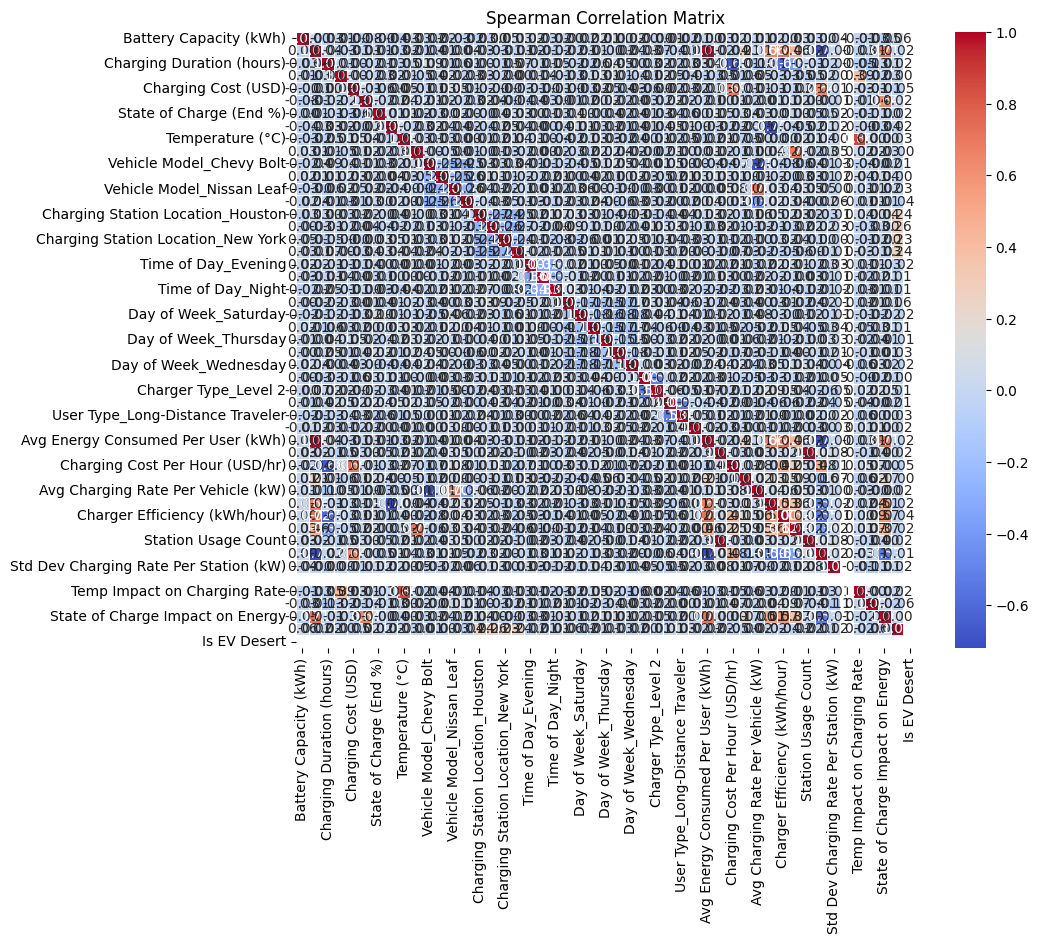

In [71]:
# Calculate Spearman correlation (non-linear relationships)
spearman_correlation_matrix = numeric_df.corr(method='spearman')

# Print the Spearman correlation matrix
print("Spearman Correlation Matrix:")
print(spearman_correlation_matrix)

# Visualize the Spearman correlation matrix with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Spearman Correlation Matrix')
plt.show()

In [60]:
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                                          Battery Capacity (kWh)  \
Battery Capacity (kWh)                                  1.000000   
Energy Consumed (kWh)                                   0.000328   
Charging Duration (hours)                              -0.024824   
Charging Rate (kW)                                      0.015691   
Charging Cost (USD)                                    -0.000492   
State of Charge (Start %)                              -0.072148   
State of Charge (End %)                                -0.011512   
Distance Driven (since last charge) (km)               -0.040130   
Temperature (°C)                                       -0.036411   
Vehicle Age (years)                                     0.037673   
Vehicle Model_Chevy Bolt                               -0.014965   
Vehicle Model_Hyundai Kona                              0.020972   
Vehicle Model_Nissan Leaf                              -0.040806   
Vehicle Model_Tesla Model 3 

In [62]:
print(df.isna().sum())  # Check for missing values
print(df.describe())  # Check for extreme values in numeric columns


User ID                                       0
Battery Capacity (kWh)                        0
Charging Station ID                           0
Charging Start Time                           0
Energy Consumed (kWh)                         0
Charging Duration (hours)                     0
Charging Rate (kW)                            0
Charging Cost (USD)                           0
State of Charge (Start %)                     0
State of Charge (End %)                       0
Distance Driven (since last charge) (km)      0
Temperature (°C)                              0
Vehicle Age (years)                           0
Vehicle Model_Chevy Bolt                      0
Vehicle Model_Hyundai Kona                    0
Vehicle Model_Nissan Leaf                     0
Vehicle Model_Tesla Model 3                   0
Charging Station Location_Houston             0
Charging Station Location_Los Angeles         0
Charging Station Location_New York            0
Charging Station Location_San Francisco 

In [ ]:
# checking feature importance

# Assume 'Charging Cost' is your target
X = df.drop(columns=['Charging Cost (USD)'])
y = df['Charging Cost (USD)']

# Fit a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Get feature importances
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index=X.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)


## Splitting the Data

In [ ]:

# Split into features (X) and target (y)
X = df.drop(columns=['Charging Cost'])  # assuming Charging Cost is your target
y = df['Charging Cost']

# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
